# Leaky integrate and fire model

### This neuron model is one of the simplest models available to simulate neuron behavior(passive membrane simulation). its only a simple diffrential equation!! it cant simulate the `fire` state but its accurate enough for passive membrane behavior. 



In [1]:
# import libraries
import torch
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. generating the input current
time = np.arange(1, 101, 0.05)
value = [1000.0]
j = 1
for i in range(1, len(time)):
  if i % 500 == 0:
    j += 1
  value.append(j * 1000)
current = pd.DataFrame({'time' : time, 
                        'value' : value})
current.head(-10)

,time,value
0,1.00,1000.0
1,1.05,1000.0
2,1.10,1000.0
3,1.15,1000.0
4,1.20,1000.0
...,...,...
1985,100.25,4000.0
1986,100.30,4000.0
1987,100.35,4000.0
1988,100.40,4000.0


In [3]:
def plot_current(df):
  plt.figure(figsize = (6, 4))
  plt.plot(df.iloc[:, 0], df.iloc[:, 1])
  plt.xlabel('time(ms)')
  plt.ylabel('current(pA)')

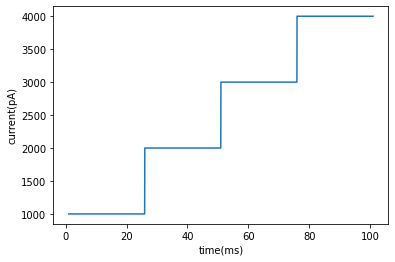

In [4]:
# plotting the input current diagram
plot_current(current)

In [5]:
# 2. creating dataloader
class CurrentDataset(torch.utils.data.Dataset):

  def __init__(self, path = None, data_frame = None):
    # self.path = path
    # if data_frame != None:
    self.data = data_frame
    # else:
    #   self.data = pd.read_csv(self.path)
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    if torch.is_tensor(index):
      index = index.tolist()
    sample = self.data.loc[index].values
    return torch.tensor(sample)

## 3. implementing the neuron model with `torch.nn.Module`

LIF model is a single diffrential equation in form of $du = dt(-(u - u_rest) + RI(t)) / \tau$.$\tau$ and $R$ are the main parameeters of our model.

we initialize and set the model parameters with `__init__` method. Because we inherited from the `torch.nn.Module` class, we must override the `forward()` method which is the main part of our model. we should implement our diffrential equation in `forward()` method.`self.data` is a tensor which stores the potential difference information of our model over time. after calculating the potential difference($du$) we need to check if we have reached the threshold or not, if yes, our neuron should spike! but LIF model can't simulate the fire state, so when we are in threshold state, we just reporalize quikly, therefore we expect potential changes to be like this diagram below:
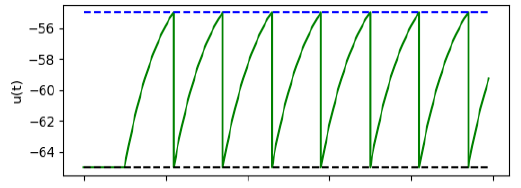

(the blue line indicates the threshold and the black line indicates the rest potential)

In [6]:
class LIF(torch.nn.Module):

  def __init__(self, r, t, u_r, theta): # r = electrical resistance, t = Tau, u_r = rest potential, theta = threshold

    super(LIF, self).__init__()
    self.r = r
    self.t = t
    self.u = u_r
    self.u_r = u_r
    self.theta = theta
    self.time = 0
    self.data = torch.tensor([self.time, self.u])

  def forward(self, data): # data is a tensor object that contains time and potential(data[0] = time , data[1] = potential)

    dt = data[0] - self.time
    self.time = data[0]
    du = dt * (-1 * (self.u - self.u_r) + self.r * data[1]) / self.t # the neuron dynamic diffrential equation
    self.u += du
    self.data = torch.vstack((self.data, torch.tensor([self.time, self.u])))

    if self.u > self.theta:
      self.repolarization()
      return torch.tensor([self.time, 1]) # the fire state
    else:
      return torch.tensor([self.time, 0]) # the neuron doesnt fire

  def reset(self):
    self.u = self.u_r
    self.time = 0
    self.data = torch.tensor([self.time, self.u])
  
  def repolarization(self):
    self.u = self.u_r


In [7]:
# run our model with input current
def process(model, data):
  is_spike = None
  for x in data:
    res = model(x[0])
    if is_spike is None:
      is_spike = res
    else:
      is_spike = torch.vstack((is_spike, res))
  return is_spike

In [8]:
# plot spikes
def plot_spike(spikes):
  spikes = spikes[spikes[:, 1] == 1]
  plt.figure(figsize = (6, 4))
  plt.title('spikes')
  plt.scatter(spikes[:, 0], spikes[:, 1], marker = '|', c = "g")
  plt.xlabel('time(ms)')

In [22]:
# the model parameters
r = 0.1 # M ohm

t = 70 # ms

u_r = -70 # mV

theta = -50 # mV

model = LIF(r, t, u_r, theta)

In [23]:
def plot_potential(data):
  plt.figure(figsize = (6, 4))
  plt.plot(data[:, 0], data[:, 1], c = 'black')
  plt.xlabel('time(ms)')
  plt.ylabel('u(mV)')
  plt.title('potential diagram')

In [24]:
current_data = CurrentDataset(data_frame = current)
current_data_loader = torch.utils.data.DataLoader(current_data ,batch_size=1,shuffle=False)
spikes = process(model, current_data_loader)
spikes

tensor([[  1.0000,   0.0000],
        [  1.0500,   0.0000],
        [  1.1000,   0.0000],
        ...,
        [100.8500,   0.0000],
        [100.9000,   0.0000],
        [100.9500,   0.0000]], dtype=torch.float64)

In [25]:
def plot_general(current, spikes, data):
  fig, axs = plt.subplots(3, figsize = (10, 10))
  
  axs[0].plot(current.iloc[:, 0], current.iloc[:, 1])
  axs[0].set_title('input current')
  axs[0].set(xlabel = 'time (ms)', ylabel = 'current (pA)')
  axs[0].label_outer()
  
  spikes = spikes[spikes[:, 1] == 1]
  axs[1].scatter(spikes[:, 0], spikes[:, 1], marker = '|', c = 'orange')
  axs[1].set_title('spikes')
  axs[1].set(xlabel = 'time (ms)')
  axs[1].label_outer()

  axs[2].plot(data[:, 0], data[:, 1], c = 'green')
  axs[2].set_title('potential')
  axs[2].set(xlabel = 'time (ms)', ylabel = 'u (mV)')
  axs[2].label_outer()

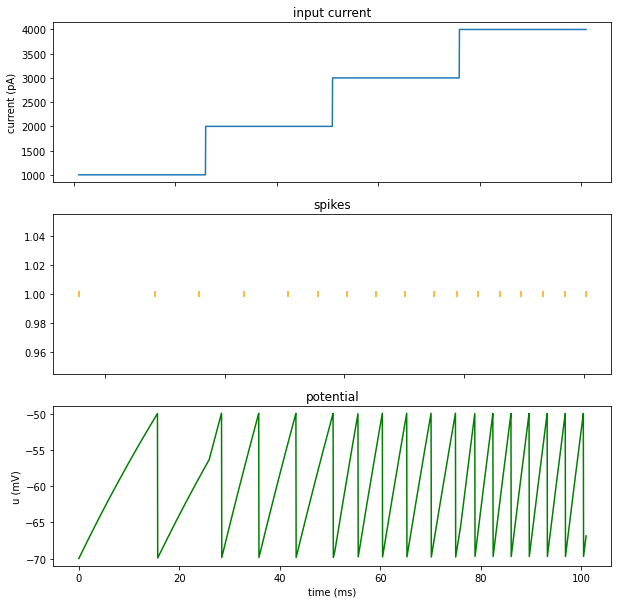

In [26]:
plot_general(current, spikes, model.data)

As can be seen in above diagrams, when input current is constant, the potential changes linearly and when the input current increases, more spikes are observed and potential growth faster(green diagram).

## random input current

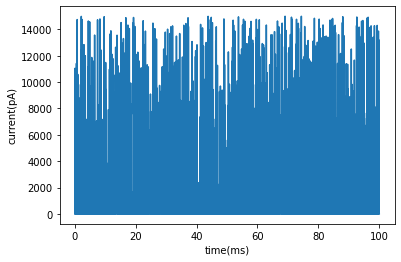

In [27]:
random_current = pd.read_csv('random_current.csv')
plot_current(random_current)

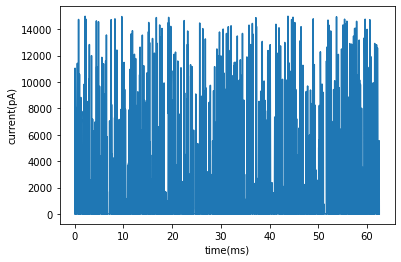

In [28]:
# this dataset is very large, let us only use 2000 of it!
random_current = random_current[:2001]
plot_current(random_current)

In [29]:
# first we should reset our model
model.reset()

In [30]:
current_data = CurrentDataset(data_frame = random_current)
current_data_loader = torch.utils.data.DataLoader(current_data ,batch_size=1,shuffle=False)
spikes = process(model, current_data_loader)
spikes

tensor([[3.1250e-02, 0.0000e+00],
        [6.2500e-02, 0.0000e+00],
        [9.3750e-02, 0.0000e+00],
        ...,
        [6.2469e+01, 0.0000e+00],
        [6.2500e+01, 0.0000e+00],
        [6.2531e+01, 0.0000e+00]], dtype=torch.float64)

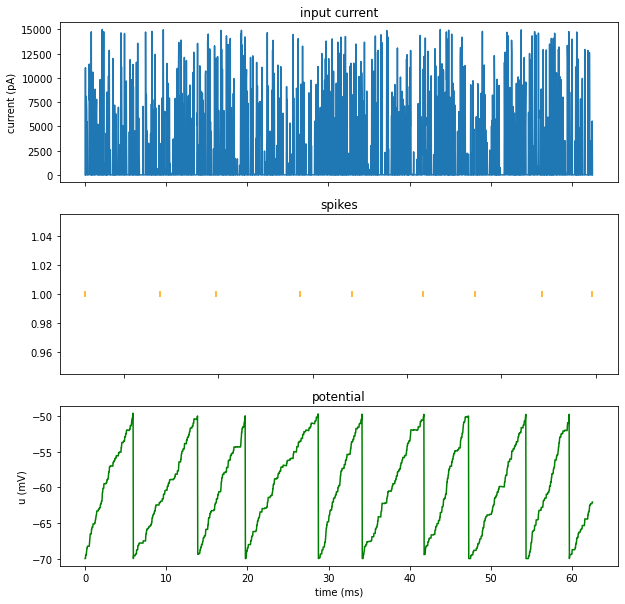

In [31]:
plot_general(random_current, spikes, model.data)

As can be seen in above diagrams, the potential doesnt change linearly!
and also there is no specific pattern in the spikes.

## Why LIF model behaves like this?

becuase of the equation : $du = dt * (-(u - u_rest) + RI(t))/\tau$
the potential-time equation will be $u(t) = u_rest + RI(t)[1 - e^{-t/\tau}]$

according to the above relationship, the input current has a direct relationship with the potential value. so when $I$ increases by time, $u$ also increases.


## Run model with different parameters
### as mentioned earlier, the main parameters of our model are:


*   $\tau$ (time constant)
*   $R$ (resistance)




